# Part3_Optional_Exercise

In this optional exercise, you will try to improve the network classification performance by adding a new convolutional layer to the network defined in Part1.

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np

### 1. Loading and normalizing CIFAR10



In [35]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified





### 2. Visualizing the training images


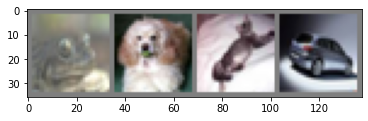

 frog   dog   cat   car


In [36]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Optional exercise: Adding an additional conv layer
----------------
In this part, you will modify the network by adding one additional convolutional layer after the conv2 layer using the nn.Conv2d function.
You can find the docs of nn.Conv2d function here https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d.

For example, in self.conv1 = nn.Conv2d(3, 6, 3, padding=1), the first parameter 3 is the input feature dimension, the second parameter 6 is the output feature dimension and the third parameter 3 is the kernel size for squared kernels. Padding controls the number of implicit zero-paddings on both sides.

You can find the equation to calculated the feature map size in the lab manual or in the pytorch doc here https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d.

You should choose 32 as the output feature dimension for the additional conv layer.

To maintain the spatial resolution of the feature map, we do not use a pooling layer after the third conv layer.

When you have successfully modified the network, you can run the following codes to train and test your model.

### 3. Modifying the network (To do)

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)
        
        # Append 1 more conv layers here
        # Set the output dimension of your last conv layer
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)

        
        self.fc1 = nn.Linear(32 * 8 * 8, 120)
        #Initialize the first fc layer with correct input dimensions
        # To Do
                

        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # To Do
        x = F.relu(self.conv3(x))

        # Add in the new conv layers
        x = x.view(-1, 32 * 8 * 8)
        # To Do

        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 4. Printing the modified network

In [38]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 5. Showing the modified network structure using Torchsummary

In [39]:
from torchsummary import summary
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
         MaxPool2d-2            [-1, 6, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]             880
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 32, 8, 8]           4,640
            Linear-6                  [-1, 120]         245,880
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 262,582
Trainable params: 262,582
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 1.00
Estimated Total Size (MB): 1.13
----------------------------------------------------------------


### 6. Training the modified network

In [40]:
import torch.optim as optim
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
t1 = time.time()
loss_list = []
for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_list.append(running_loss/2000)
            running_loss = 0.0

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

PATH = './cifar_net_3convlayer.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 2.264
[1,  4000] loss: 1.984
[1,  6000] loss: 1.766
[1,  8000] loss: 1.617
[1, 10000] loss: 1.507
[1, 12000] loss: 1.419
[2,  2000] loss: 1.334
[2,  4000] loss: 1.307
[2,  6000] loss: 1.275
[2,  8000] loss: 1.256
[2, 10000] loss: 1.198
[2, 12000] loss: 1.193
[3,  2000] loss: 1.104
[3,  4000] loss: 1.087
[3,  6000] loss: 1.073
[3,  8000] loss: 1.084
[3, 10000] loss: 1.047
[3, 12000] loss: 1.024
Finished Training
Training time:217.76226139068604


### 7. Making prediction and visualization

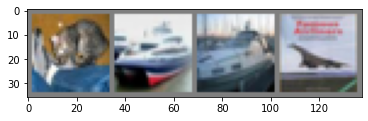

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship truck  ship


In [41]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

### 8. Performance evaluation

In [42]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 63 %
Accuracy of plane : 66 %
Accuracy of   car : 78 %
Accuracy of  bird : 42 %
Accuracy of   cat : 40 %
Accuracy of  deer : 43 %
Accuracy of   dog : 59 %
Accuracy of  frog : 82 %
Accuracy of horse : 70 %
Accuracy of  ship : 73 %
Accuracy of truck : 78 %
